<p align=center>
<img src="assets/cphbanner.png" width=1280>
</p>

# **Project 1: Survival Analysis and Prediction [30 points]**

Many clinical trials and observational studies involve following patients for a long time. The primary event of
interest in those studies may include death, relapse, or the onset of a new disease. The follow-up time for a trial
or a study may range from few weeks to many years. To analyze this data, we typically conduct time-to-event
analysis and build predictive models that learn time-to-event distributions. The goal of this project is to test
your ability to conduct basic survival analyses as well as develop ML models for survival prediction.

**Please submit your report and code by <u> Tuesday 2/4 11:59 PST </u>.**

## Task 1.1: Nonparametric Survival Analysis in Heart Failure [7 pts]

Nonparametric models of survival data do not make parametric assumptions on the distribution of timeto-event outcomes. They are widely used in clinical studies to derive descriptive statistics of survival in a population. In this task, we will apply standard nonparametric estimators to analyze survival of heart failure patients in a recent, widely-recognized study [1].

####  Setup and Dataset

The dataset we will use in this task was extracted from the electronic health records (EHRs) of 299 heart failure patients from the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015. The cohort included 105 women and 194 men, and their ages range between 40 and 95 years old. All 299 patients had left ventricular systolic dysfunction and had previous heart failures (HF) that put them in classes III or IV of New York Heart Association (NYHA) classification of the stages of heart failure. The dataset contains 13 features, which report clinical, body, and lifestyle information. The patients were followed up for 130 days on average (maximum follow-up period was 285 days). The event of interest was death during the follow-up period.

The dataset is publicly accessible and was shared with the class through UCSF Box. You can load the dataset in the directory "./data" and inspect all the features/outcomes using pandas as follows:

In [25]:
import pandas as pd

dataset = pd.read_csv("data/heart_failure_clinical_records_dataset.csv")

In [2]:
dataset

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [3]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [76]:
from lifelines import KaplanMeierFitter

import matplotlib.pyplot as plt

import math
import torch

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


## 1.1 Non parametric Survival

In [5]:
# Implement the Kaplan-Meier point estimator from scratch in Python. 
# Apply your estimator to the dataset described above to estimate survival in HF patients.

### 1.1.1

In [6]:
def q_estimator(step, dataset):
    total_n = len(dataset)
    out_before_step = len(dataset[dataset["time"]<step])
    nt = total_n - out_before_step
    dt = dataset[dataset["time"]==step]["DEATH_EVENT"].sum()
    q = dt/nt
    return q

def s_estimator(dataset):
    s_estimate = [1]
    time_steps = list(dataset["time"].unique())

    for step in time_steps:
        q_estimate = q_estimator(step, dataset)
        s_estimate.append(s_estimate[-1]*(1-q_estimate))
    
    time_steps.insert(0, 0)

    return s_estimate, time_steps
    


In [7]:
s_estimate, time_steps = s_estimator(dataset)

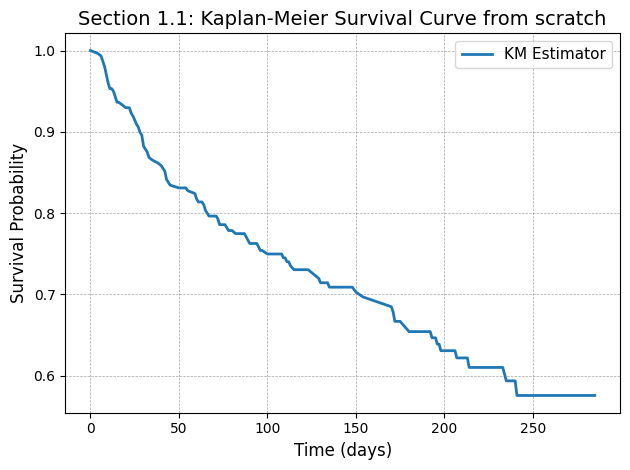

In [8]:
plt.plot(time_steps, s_estimate, label="KM Estimator", color="#1f77b4", linewidth=2)

# Add labels, title, and grid
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.title("Section 1.1: Kaplan-Meier Survival Curve from scratch", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=11, loc="best")
plt.tight_layout()
plt.show()

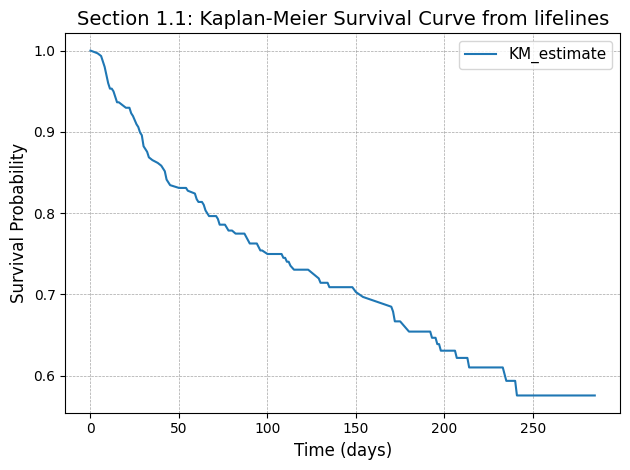

In [9]:
# Then, compare your results with the built-in functions in lifelines library.
kmf = KaplanMeierFitter()
kmf.fit(dataset["time"], dataset["DEATH_EVENT"])

kmf.survival_function_.plot()

plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.title("Section 1.1: Kaplan-Meier Survival Curve from lifelines", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=11, loc="best")
plt.tight_layout()
plt.show()

In [10]:
#kmf.plot_survival_function()

### 1.1.2

In [11]:
def survival_function(t, beta):
    return math.exp(-beta * t)

In [12]:
sum_censored = dataset['DEATH_EVENT'].sum()
sum_times = dataset['time'].sum()

beta_hat = sum_censored/sum_times

In [13]:
max_t = dataset['time'].max()
time_steps = list(range(0,max_t))
s_estimate = [survival_function(t,beta_hat) for t in time_steps]


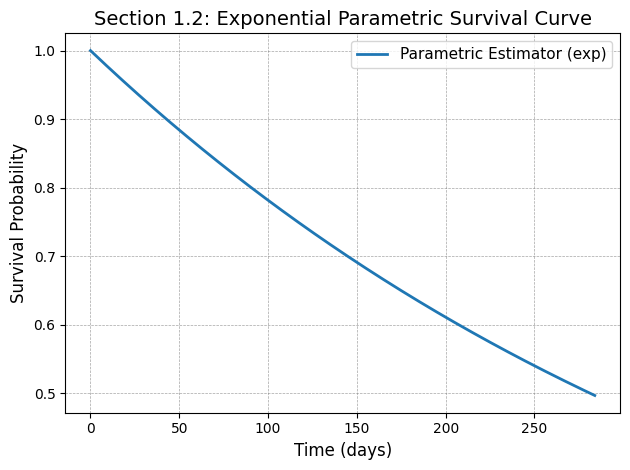

In [14]:
plt.plot(time_steps, s_estimate, label="Parametric Estimator (exp)", color="#1f77b4", linewidth=2)

# Add labels, title, and grid
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.title("Section 1.2: Exponential Parametric Survival Curve", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=11, loc="best")
plt.tight_layout()
plt.show()

### 1.1.3

In [15]:
from scipy.spatial.distance import cdist
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler

In [16]:
def normalize_data(data, features):
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    return data, scaler

def nn_keplen_meier_individual(dataset, patient, features, n_neighbors):
    query_vector = patient[features].values.reshape(1, -1)
    distances = cdist(dataset[features], query_vector, metric='euclidean').flatten()
    dataset["distance"] = distances
    nearest_neighbors = dataset.sort_values(by='distance').iloc[:n_neighbors]
    kmf = KaplanMeierFitter()
    kmf.fit(durations=nearest_neighbors['time'], event_observed=nearest_neighbors['DEATH_EVENT'])
    return kmf

def nn_keplen_meier(dataset, features, n_neighbors=20):
    kmf_estimations = []
    normalized_data, _ = normalize_data(dataset.copy(), features)
    for idx, patient in normalized_data.iterrows():
        data_excluding_patient = normalized_data.drop(idx)
        kmf = nn_keplen_meier_individual(data_excluding_patient, patient, features, n_neighbors)
        kmf_estimations.append(kmf)
    return kmf_estimations


In [17]:
features = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking',]
n_neighbors=25
time_point=150

nn_keplen_meier_estimation = nn_keplen_meier(dataset, features, n_neighbors)
survival_predictions = [kmf.survival_function_at_times([time_point]).values[0] for kmf in nn_keplen_meier_estimation]

survival_times = dataset['time'].values
events = dataset['DEATH_EVENT'].values
c_index = concordance_index(survival_times, survival_predictions, events)

print(c_index)

0.6884903486027082


## Task 1.2: Survival Prediction in HF patients using the Cox Model [7 pts]

### 1.2.1

In [18]:
import numpy as np
import torch.nn as nn
import torch.optim as optim


In [19]:
class LinearRisk(nn.Module):
    def __init__(self, input_dim):
        super(LinearRisk, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False) 
        nn.init.normal_(self.linear.weight, mean=0.0, std=0.01)

    def forward(self, X):
        return self.linear(X) 

def partial_likelihood_loss(model, dataset, input_columns, time_column = "time", event_column = "DEATH_EVENT"):
    # Extract features and times
    X = torch.tensor(dataset[input_columns].values, dtype=torch.float32)
    times = torch.tensor(dataset[time_column].values, dtype=torch.float32)
    events = torch.tensor(dataset[event_column].values, dtype=torch.float32)

    # Compute linear scores and risk scores
    linear_scores = model(X).squeeze()  # Shape: (n_patients,)
    risk_scores = torch.exp(linear_scores)

    # Sort patients by time (descending)
    sorted_indices = torch.argsort(times, descending=True)
    linear_scores = linear_scores[sorted_indices]
    risk_scores = risk_scores[sorted_indices]
    events = events[sorted_indices]

    # Compute log-partial likelihood
    log_cumulative_hazard = torch.log(torch.cumsum(risk_scores, dim=0))
    log_likelihood = linear_scores - log_cumulative_hazard
    neg_log_likelihood = -torch.sum(events * log_likelihood)

    return neg_log_likelihood

In [20]:
# Initialize dataset, model, and optimizer
input_columns = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
                 'ejection_fraction', 'high_blood_pressure', 'platelets',
                 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']

model = LinearRisk(input_dim=len(input_columns))  # 1-layer NN for linear risk
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1000
training_data, scaler = normalize_data(dataset.copy(), input_columns)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = partial_likelihood_loss(model, training_data, input_columns)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 508.0915
Epoch 100, Loss: 490.8505
Epoch 200, Loss: 480.7729
Epoch 300, Loss: 475.2629
Epoch 400, Loss: 472.2374
Epoch 500, Loss: 470.4644
Epoch 600, Loss: 469.3960
Epoch 700, Loss: 468.7673
Epoch 800, Loss: 468.4144
Epoch 900, Loss: 468.2270


In [21]:
# Report coefficients
model_coefficients = model.linear.weight.detach().numpy().flatten()
print("Model Coefficients:")
coefficients_df = pd.DataFrame({"Column":input_columns, "Coefficient":model_coefficients})
print(coefficients_df)

coefficients_df.to_csv("Model_coefficients_part21.csv")

Model Coefficients:
                      Column  Coefficient
0                        age     0.520659
1                    anaemia     0.226471
2   creatinine_phosphokinase     0.212192
3                   diabetes     0.060030
4          ejection_fraction    -0.545407
5        high_blood_pressure     0.226810
6                  platelets    -0.042735
7           serum_creatinine     0.326571
8               serum_sodium    -0.204339
9                        sex    -0.106607
10                   smoking     0.056424


In [22]:
# Since I normalized the features I need to undo the normalization
# Get scaler parameters
scaler_means = scaler.mean_  
scaler_stds = scaler.scale_ 

# Create an empty list to store results
unscaled_betas = []

for i, feature in enumerate(input_columns):
    # Get the scaled beta for the feature
    scaled_beta = coefficients_df.loc[coefficients_df["Column"] == feature, "Coefficient"].values[0]
    
    # Reverse normalization: unscaled_beta = scaled_beta * std
    unscaled_beta = scaled_beta / scaler_stds[i]
    hazard_ratio = np.exp(unscaled_beta)     # Compute Hazard Ratio (HR): HR = exp(unscaled_beta)
    
    # Append results
    unscaled_betas.append({
        "Column": feature,
        "Coefficient": scaled_beta,
        "Unscaled Coefficient": unscaled_beta,
        "Hazard Ratio": hazard_ratio
    })

# Convert to a DataFrame
unscaled_coefficients_df = pd.DataFrame(unscaled_betas).round(3)
unscaled_coefficients_df.to_csv("Unscaled_model_coeffs_part_21.csv")

# Display the results
print(unscaled_coefficients_df)


                      Column  Coefficient  Unscaled Coefficient  Hazard Ratio
0                        age        0.521                 0.044         1.045
1                    anaemia        0.226                 0.457         1.580
2   creatinine_phosphokinase        0.212                 0.000         1.000
3                   diabetes        0.060                 0.122         1.129
4          ejection_fraction       -0.545                -0.046         0.955
5        high_blood_pressure        0.227                 0.475         1.608
6                  platelets       -0.043                -0.000         1.000
7           serum_creatinine        0.327                 0.316         1.372
8               serum_sodium       -0.204                -0.046         0.955
9                        sex       -0.107                -0.223         0.800
10                   smoking        0.056                 0.121         1.128


### 1.2.2

In [23]:
survival_times = dataset['time'].values
events = dataset['DEATH_EVENT'].values
X = torch.tensor(training_data[input_columns].values, dtype=torch.float32)
linear_scores = model(X).squeeze()  
risk_scores = torch.exp(linear_scores).detach().numpy()
survival_predictions = 1-risk_scores

c_index = concordance_index(survival_times, survival_predictions, events)

print(c_index)

0.7415730337078652


### 1.2.3


In [24]:
dataset.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [25]:
# add interaction term
training_data = dataset.copy()
training_data["age_sex"] = training_data["age"] * dataset["sex"]

# Initialize dataset, model, and optimizer
input_columns = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
                 'ejection_fraction', 'high_blood_pressure', 'platelets',
                 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'age_sex']

model = LinearRisk(input_dim=len(input_columns))  # 1-layer NN for linear risk
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1000
training_data, scaler = normalize_data(training_data, input_columns)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = partial_likelihood_loss(model, training_data, input_columns)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 509.3091
Epoch 100, Loss: 490.7278
Epoch 200, Loss: 479.8495
Epoch 300, Loss: 474.0891
Epoch 400, Loss: 471.1405
Epoch 500, Loss: 469.5639
Epoch 600, Loss: 468.6916
Epoch 700, Loss: 468.2150
Epoch 800, Loss: 467.9644
Epoch 900, Loss: 467.8384


In [26]:
# Report coefficients
model_coefficients = model.linear.weight.detach().numpy().flatten()
print("Model Coefficients:")
coefficients_df = pd.DataFrame({"Column":input_columns, "Coefficient":model_coefficients})
print(coefficients_df)

coefficients_df.to_csv("Model_coefficients_part22.csv")

Model Coefficients:
                      Column  Coefficient
0                        age     0.435142
1                    anaemia     0.220876
2   creatinine_phosphokinase     0.204392
3                   diabetes     0.059552
4          ejection_fraction    -0.542505
5        high_blood_pressure     0.222263
6                  platelets    -0.042151
7           serum_creatinine     0.321274
8               serum_sodium    -0.196461
9                        sex    -0.515396
10                   smoking     0.062518
11                   age_sex     0.411315


In [27]:
# Since I normalized the features I need to undo the normalization
# Get scaler parameters
scaler_means = scaler.mean_  
scaler_stds = scaler.scale_ 

# Create an empty list to store results
unscaled_betas = []

for i, feature in enumerate(input_columns):
    # Get the scaled beta for the feature
    scaled_beta = coefficients_df.loc[coefficients_df["Column"] == feature, "Coefficient"].values[0]
    
    # Reverse normalization: unscaled_beta = scaled_beta * std
    unscaled_beta = scaled_beta / scaler_stds[i]
    hazard_ratio = np.exp(unscaled_beta)     # Compute Hazard Ratio (HR): HR = exp(unscaled_beta)
    
    # Append results
    unscaled_betas.append({
        "Column": feature,
        "Coefficient": scaled_beta,
        "Unscaled Coefficient": unscaled_beta,
        "Hazard Ratio": hazard_ratio
    })

# Convert to a DataFrame
unscaled_coefficients_df = pd.DataFrame(unscaled_betas).round(3)
unscaled_coefficients_df.to_csv("Unscaled_model_coeffs_part_22.csv")

# Display the results
print(unscaled_coefficients_df)


                      Column  Coefficient  Unscaled Coefficient  Hazard Ratio
0                        age        0.435                 0.037         1.037
1                    anaemia        0.221                 0.446         1.562
2   creatinine_phosphokinase        0.204                 0.000         1.000
3                   diabetes        0.060                 0.121         1.128
4          ejection_fraction       -0.543                -0.046         0.955
5        high_blood_pressure        0.222                 0.466         1.593
6                  platelets       -0.042                -0.000         1.000
7           serum_creatinine        0.321                 0.311         1.365
8               serum_sodium       -0.196                -0.045         0.956
9                        sex       -0.515                -1.080         0.340
10                   smoking        0.063                 0.134         1.143
11                   age_sex        0.411                 0.013 

## Task 1.3: Deep Survival Prediction for Heart Transplantation [8 pts]

####  Setup and Dataset

For this task, we will use data collected by the United Network for Organ Sharing (UNOS) [2], a non-profit organization that administers the only Organ Procurement and Transplantation Network (OPTN) in the US. UNOS is involved in many aspects of the organ transplant and donation process in the US, including data collection and maintenance, providing assitance to patients and care takers, and informing policy makers on the best use of the limited supply of organs and give all patients a fair chance at receiving the organ they need. UNOS manages the heart transplant waiting list, i.e., the list of terminally-ill patients waiting for donor heart. In order to determine the order of priority for receipt of a donor heart, individuals are classified by degrees of severity for a donor heart, blood type, body weight, and geographic location.

This Task will focus on the cohort of terminally-ill patients who are enrolled in the wait-list for heart transplantation. In this setup, our goal is to predict the patients who are less likely to survive in order to prioritize them for receiving donated organs. The UNOS data covers 30 years of heart transplantation data in the US, spanning the years from 1985 to 2015. We will use data for patients who were on the wait-list for heart transplantation in the US from 1985 to 2010 (27,926 patients) to train an ML-based model for predicting individual-level survival. A held-out test set of 8,403 patients enrolled in the wait-list between 2010 and 2015 will be used by the instructor to evaluate your model. You can load the UNOS data in pandas as follows.

In [28]:
UNOS_data           = pd.read_csv("data/UNOS_train.csv")

#### Feature Dictionary

Each patient's record in the UNOS database is associated with the following variables:

In [29]:
patient_variables   = ["init_age", "gender", "hgt_cm_tcr", "wgt_kg_tcr", "diab", "ventilator_tcr",
                       "ecmo_tcr", "most_rcnt_creat", "abo_A", "abo_B", "abo_O", "vad_while_listed",
                       "days_stat1", "days_stat1a", "days_stat2", "days_stat1b", "iabp_tcr",
                       "init_bmi_calc", "tah", "inotropic", "Censor (Censor = 1)", "Survival Time"]

In [30]:
# Filter patients with negative survival times-  unsure what the explanation is

UNOS_data = UNOS_data[UNOS_data['Survival Time']>=0]

In [31]:
UNOS_data['Survival Time'].min()

np.int64(0)

The interpretation of each variable is provided below:

- "init_age": Patient's age at time of enrolling in the wait-list
- "gender": Patient's biological sex
- "hgt_cm_tcr": Patient's height in cm
- "wgt_kg_tcr": Patient's weight in kgs
- "diab": Indication on whether or not the patient is diabetic
- "abo_A": Indication on whether patient's blood type is A
- "abo_B": Indication on whether patient's blood type is B
- "abo_O": Indication on whether patient's blood type is O
- "ventilator_tcr": Indication on whether the patient was dependent on a ventilator at time of enrollment in the wait-list
- "ecmo_tcr": Indication on whether the patient was treated with ECMO (extracorporeal membrane oxygenation) by the time they where enrolled in the wait-list. ECMO is an artificial life support that continuously pumps blood out of the patient's body and sends it through a series of devices that add oxygen and remove carbon dioxide, pumping the blood back to the patient. It is used for a patient whose heart and lungs are not functioning properly.  
- "most_rcnt_creat": Creatinine level in the patient's most recent blood test before enrolling in wait-list.
- "vad_while_listed": Whether the patient was on ventricular assist device (VAD) support when listed for a heart transplant. VAD is a mechanical pump used to restore cardiac function by pumping blood from the lower chambers of the heart to the rest of the body.
- "iabp_tcr": Whether the patient was on Intra-Aortic Balloon Pump (IABP) Therapy. This is a therapeutic device used to improve blood flow when the heart is unable to pump enough blood for your body.
- "init_bmi_calc": Patient's Body Mass Index at time of enrollment in the wait-list.
- "tah": Whether the patient underwent a total artificial heart (TAH) surgery. This is a mechanical pump that replaces the heart when it is not working as it should.
- "inotropic": Whether the patient was on an Inotropic drug at time of enrollment in wait-list. These are medicines that change the force of the heart's contractions.
- "days_stat1", "days_stat1a", "days_stat1b", "days_stat2": UNOS has an internal system for classifying the priority of patients for receiving a heart transplant. Individuals classified as Status 1A have the highest priority on the heart transplant waiting list. Status 1A are individuals who must stay in the hospital as in-patients and require high doses of intravenous drugs, require a VAD for survival, are dependent on a ventilator or have a life expectancy of a week or less without a transplant. Individuals classified as Status 1B are generally not required to stay in the hospital as in-patients. All other candidates for the transplant are listed under Status 2. These variables indicate the number of days a patient spends in each status during the time between their enrollment in the wait-list and death or reception of a transplant.
- "Censor (Censor = 1)": Indication of censoring
- "Survival Time": Time between enrollment in wait-list and death

## Solution

In [32]:
from sklearn.model_selection import KFold
import pickle

In [33]:
def partial_likelihood_with_L2_reg(model, dataset, input_columns, lambda_reg, time_column, event_column):
    # Compute the negative log partial likelihood
    neg_log_likelihood = partial_likelihood_loss(model, dataset, input_columns, time_column, event_column)
    
    # Compute L2 regularization term
    l2_reg = sum(torch.sum(param ** 2) for param in model.parameters())

    # Add regularization to the loss
    total_loss = neg_log_likelihood + 0.5 * lambda_reg * l2_reg

    return total_loss

In [36]:
class DeepSurv(nn.Module):
    ''' The module class performs building network according to config'''
    def __init__(self, dimensions: list, dropout = 0.1, normalization=True, activation = "ReLU" ):
        """Initialize DeepSurv model. 
        Args:
        - dimensions: list with the dimensions of each hidden layer. the len of dimensions will be the number of blocks
            First item is the input dimension, and last item is the output dimension. 
        - dropout: proportion of dropout (float)
        - normalization: boolean flag to to apply BatchNorm
        - activation: which activation function to use"""
        super(DeepSurv, self).__init__()
        self.model = self._build_model(dimensions, dropout, normalization, activation)

    def _build_model(self, dimensions, dropout, normalization, activation):
        layers = []
        # To do: update
        for i in range(len(dimensions)-2):
            layers.append(nn.Linear(dimensions[i], dimensions[i+1]))
            if normalization: 
                layers.append(nn.BatchNorm1d(dimensions[i+1]))
            layers.append(eval('nn.{}()'.format(activation)))
            if dropout is not None: 
                layers.append(nn.Dropout(dropout))
        # final layer
        layers.append(nn.Linear(dimensions[-2], dimensions[-1]))

        # builds sequential network
        return nn.Sequential(*layers)

    def forward(self, X):
        return self.model(X)

In [37]:
UNOS_data["DEATH_EVENT"] = np.logical_not(UNOS_data["Censor (Censor = 1)"]).astype(int)

columns_to_ignore = ["days_stat1", "days_stat1a", "days_stat2", "days_stat1b"]
censor_col = "Censor (Censor = 1)"
death_col = "DEATH_EVENT"
survival_time_col = "Survival Time"

input_columns = [p for p in patient_variables if p not in columns_to_ignore+[censor_col]+[survival_time_col]+[death_col]]

In [38]:
# No cross validation

model = DeepSurv(dimensions = [len(input_columns), 20, 20, 20, 1],)  # 1-layer NN for linear risk
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1000
training_data, scaler = normalize_data(UNOS_data.copy(), input_columns)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = partial_likelihood_with_L2_reg(model, training_data, input_columns, 0.1, survival_time_col, death_col)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

survival_times = UNOS_data[survival_time_col].values
events = UNOS_data[death_col].values
X = torch.tensor(training_data[input_columns].values, dtype=torch.float32)
linear_scores = model(X).squeeze()  
risk_scores = torch.exp(linear_scores).detach().numpy()
survival_predictions = 1-risk_scores

c_index = concordance_index(survival_times, survival_predictions, events)

print(c_index)

Epoch 0, Loss: 154521.3438
Epoch 100, Loss: 153019.6719
Epoch 200, Loss: 152806.9219
Epoch 300, Loss: 152737.9062
Epoch 400, Loss: 152634.9844
Epoch 500, Loss: 152604.0312
Epoch 600, Loss: 152577.1094
Epoch 700, Loss: 152489.8750
Epoch 800, Loss: 152502.7344
Epoch 900, Loss: 152518.4062
0.6346725100003991


In [63]:
class SurvivalModel:
    def __init__(self, dimensions, dropout=0.1, normalization=True, activation="ReLU"):
        self.model = DeepSurv(dimensions, dropout, normalization, activation)
        self.baseline_survival = None  # Store baseline hazard parameter
        self.scaler = None # Store scaler
        self.times = np.arange(0, 3650, 180)  # Time in days (every 6 months for 10 years)

    def fit(self, X, T, C, n_epochs=1000, lr=0.001, lambda_reg=0.1, save_weights=False, print_metrics=False):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)        

        dataset = pd.DataFrame(X)
        input_columns = dataset.columns.tolist()
        dataset["Survival Time"] = T
        dataset["Censor (Censor = 1)"] = C
        dataset["DEATH_EVENT"] = np.logical_not(dataset["Censor (Censor = 1)"]).astype(int)
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            loss = partial_likelihood_with_L2_reg(self.model, dataset, input_columns, lambda_reg, "Survival Time", "DEATH_EVENT")
            loss.backward()
            optimizer.step()
            if print_metrics:
                if epoch % 100 == 0:
                    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        self.baseline_survival = self._compute_baseline_survival(T, C)

        if save_weights:
            torch.save(self.model.state_dict(), "model_weights.pth")
            with open("baseline_survival.pkl", "wb") as f:
                pickle.dump(self.baseline_survival, f)
            with open("scaler.pkl", "wb") as f:
                pickle.dump(self.scaler, f)

    def _compute_baseline_survival(self, T, C):
        kmf = KaplanMeierFitter()
        kmf.fit(T, event_observed=1 - C)  # Death event = 1 - C
        return kmf.survival_function_
    
    def predict(self, X):
        if self.scaler is None:
            raise ValueError("Scaler not found. Train the model or load parameters first.")
        X = self.scaler.transform(X) # Normalize

        X_tensor = torch.tensor(X, dtype=torch.float32) # Convert to tensor
        linear_scores = self.model(X_tensor).squeeze().detach().numpy()
        risk_scores = np.exp(linear_scores)  # Convert linear scores to risk

        if self.baseline_survival is None:
            raise ValueError("Baseline survival not found. Train the model or load parameters first.")

        # Interpolate the baseline survival function for the specified times
        baseline_values = np.interp(self.times, self.baseline_survival.index, self.baseline_survival.values.flatten())

        # Compute survival probabilities using baseline survival function
        survival_predictions = np.power(baseline_values, risk_scores[:, None])
        return survival_predictions

    def load_weights(self, model_weights_path="model_weights.pth", baseline_survival_path="baseline_survival.pkl", scaler_path="scaler.pkl"):
        """ Load model weights, baseline survival function, and scaler """
        self.model.load_state_dict(torch.load(model_weights_path))
        with open(baseline_survival_path, "rb") as f:
            self.baseline_survival = pickle.load(f)
        with open(scaler_path, "rb") as f:
            self.scaler = pickle.load(f)


In [482]:
def cross_validate(data, input_columns, param_grid, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    for params in param_grid:
        c_index_scores = []
        for train_idx, test_idx in kf.split(data):
            train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
            X_train, T_train, C_train = np.array(train_data[input_columns]), train_data["Survival Time"].values, train_data["Censor (Censor = 1)"].values
            X_test, T_test, C_test = np.array(test_data[input_columns]), test_data["Survival Time"].values, test_data["Censor (Censor = 1)"].values
            
            model = SurvivalModel(**params)
            model.fit(X_train, T_train, C_train)
            
            event_test = test_data["DEATH_EVENT"].values
            survival_prediction = model.predict(X_test)[:, 5]  # Use third time point as risk score proxy
            c_index = concordance_index(T_test, survival_prediction, event_test)
            c_index_scores.append(c_index)
        
        results.append((params, np.mean(c_index_scores)))
    
    return results

In [483]:
# Define hyperparameter grid
param_grid = [
    {"dimensions": [len(input_columns), 50, 1], "dropout": 0.1, "activation": "ReLU"},
    {"dimensions": [len(input_columns), 10, 10, 10, 10, 1], "dropout": 0.1, "activation": "ReLU"},
    {"dimensions": [len(input_columns), 20, 10, 1], "dropout": 0.1, "activation": "SELU"},
    {"dimensions": [len(input_columns), 50, 50, 1], "dropout": 0.1, "activation": "SELU"}
]

results = cross_validate(UNOS_data, input_columns, param_grid=param_grid)
for params, score in results:
    print(f"Params: {params}, C-index: {score:.4f}")

Params: {'dimensions': [16, 50, 1], 'dropout': 0.1, 'activation': 'ReLU'}, C-index: 0.6237
Params: {'dimensions': [16, 10, 10, 10, 10, 1], 'dropout': 0.1, 'activation': 'ReLU'}, C-index: 0.6029
Params: {'dimensions': [16, 20, 10, 1], 'dropout': 0.1, 'activation': 'SELU'}, C-index: 0.6216
Params: {'dimensions': [16, 50, 50, 1], 'dropout': 0.1, 'activation': 'SELU'}, C-index: 0.6266


In [71]:
train_data = UNOS_data.copy()

X_train, T_train, C_train = np.array(train_data[input_columns]), train_data["Survival Time"].values, train_data["Censor (Censor = 1)"].values

model = SurvivalModel(dimensions=[len(input_columns), 50, 50, 1], dropout= 0.1, activation= "ReLU")
model.fit(X_train, T_train, C_train, save_weights=True)

event = train_data["DEATH_EVENT"].values
risk_scores = model.predict(X_train)[:, 5]  # Use third time point as risk score proxy
c_index = concordance_index(T_train, risk_scores, event)

print(c_index)

0.6390887580741508


In [66]:
model = SurvivalModel(dimensions=[len(input_columns), 50, 50, 1])
try:
    model.load_weights()
    model.model.eval()
except FileNotFoundError:
    print("No pre-trained model weights found. Training a new model.")

/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_36629/859571609.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_w

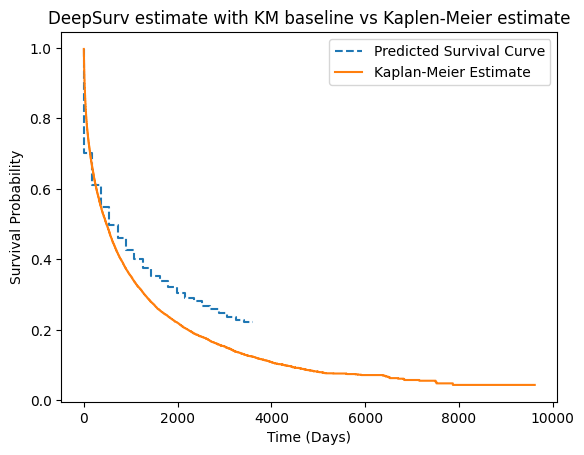

In [72]:
predictions = model.predict(X_train)
times = np.arange(0, 3650, 180)
kmf = KaplanMeierFitter()
kmf.fit(T_train, event_observed=event)

import matplotlib.pyplot as plt
plt.step(times, np.mean(predictions, axis=0), label="Predicted Survival Curve", linestyle="--")
plt.step(kmf.survival_function_.index, kmf.survival_function_.values, label="Kaplan-Meier Estimate")
plt.title("DeepSurv estimate with KM baseline vs Kaplen-Meier estimate")
plt.xlabel("Time (Days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

## Task 1.4: Handling Informative Censoring via Domain Adaptation [8 pts]

### Task 1.4.1

In [77]:
pip install numpy==2.1

Note: you may need to restart the kernel to use updated packages.


In [58]:
from pycox import datasets

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [36]:
processed_df = {
    "gbsg": datasets.gbsg.read_df(),
    "metabric": datasets.metabric.read_df(),
    "support": datasets.support.read_df(),
}

In [38]:
dataset_nwtco = datasets.nwtco.read_df(processed=False)
processed_nwtco = pd.get_dummies(dataset_nwtco, columns=['in.subcohort'], dtype=int)
old_columns = processed_nwtco.columns

processed_nwtco = processed_nwtco.drop(columns=["rownames", "seqno"])

rename_map = {"edrel": "duration", "rel": "event"}
processed_nwtco = processed_nwtco.rename(columns=rename_map)

# Rename all remaining columns to x0, x1, x2, ...
old_columns = [el for el in old_columns if el in processed_nwtco.columns]
new_column_names = {old: f"x{i}" for i, old in enumerate(old_columns)}
processed_nwtco = processed_nwtco.rename(columns=new_column_names)
processed_nwtco = processed_nwtco.fillna(-1) #Fill None with -1. Other alternatives could be considered

processed_df["nwtco"] = processed_nwtco

In [142]:
dataset_flchain = datasets.flchain.read_df(processed=False)
processed_flchain = pd.get_dummies(dataset_flchain, columns=['chapter','sex'], dtype=int)
old_columns = processed_flchain.columns

processed_flchain = processed_flchain.drop(columns=["rownames"])

rename_map = {"futime": "duration", "death": "event"}
processed_flchain = processed_flchain.rename(columns=rename_map)

# Rename all remaining columns to x0, x1, x2, ...
old_columns = [el for el in old_columns if el in processed_flchain.columns]
new_column_names = {old: f"x{i}" for i, old in enumerate(old_columns)}
processed_flchain = processed_flchain.rename(columns=new_column_names)
processed_flchain = processed_flchain.fillna(-1) #Fill None with -1. Other alternatives could be considered

processed_df["flchain"] = processed_flchain

In [143]:
# Now exclude 'chapter' feature
processed_flchain = pd.get_dummies(dataset_flchain, columns=['sex'], dtype=int)
old_columns = processed_flchain.columns

processed_flchain = processed_flchain.drop(columns=["rownames", "chapter"])

rename_map = {"futime": "duration", "death": "event"}
processed_flchain = processed_flchain.rename(columns=rename_map)

# Rename all remaining columns to x0, x1, x2, ...
old_columns = [el for el in old_columns if el in processed_flchain.columns]
new_column_names = {old: f"x{i}" for i, old in enumerate(old_columns)}
processed_flchain = processed_flchain.rename(columns=new_column_names)
processed_flchain = processed_flchain.fillna(-1) #Fill None with -1. Other alternatives could be considered

processed_df["flchainv2"] = processed_flchain

In [144]:
# No test set

def evaluate_predictive_power(df):
    features = [col for col in df.columns if col not in ["event", "duration"]]
    X, y = df[features], df["event"]
    model = LogisticRegression(max_iter=3000)
    model.fit(X, y)
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy}")
    auc = roc_auc_score(y, y_prob)
    print(f"AUC: {auc}")

for name, df in processed_df.items():
    print(name)
    evaluate_predictive_power(df)


gbsg
Accuracy: 0.6478494623655914
AUC: 0.7025297406054856
metabric
Accuracy: 0.6659663865546218
AUC: 0.7123224256171174
support
Accuracy: 0.682632705961907
AUC: 0.650502752489878
nwtco
Accuracy: 0.8629592850049652
AUC: 0.7233570607518844
flchain
Accuracy: 0.9986029972059944
AUC: 0.9999957976894565
flchainv2
Accuracy: 0.817754635509271
AUC: 0.839530246332171


In [173]:
# With test set

def evaluate_predictive_power_split(df):
    features = [col for col in df.columns if col not in ["event", "duration"]]
    X, y = df[features], df["event"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=3000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:0.2f}")
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:0.2f}")

In [146]:
for name, df in processed_df.items():
    print(name)
    evaluate_predictive_power_split(df)

gbsg
Accuracy: 0.6040268456375839
AUC: 0.6485254251211697
metabric
Accuracy: 0.6745406824146981
AUC: 0.6970019613337068
support
Accuracy: 0.6794366197183098
AUC: 0.6591885957228121
nwtco
Accuracy: 0.8523573200992556
AUC: 0.6812899832422052
flchain
Accuracy: 0.9961904761904762
AUC: 0.9995003554382045
flchainv2
Accuracy: 0.8165079365079365
AUC: 0.8393845841373007


In [175]:
def introduce_bias(data, bias_level, bias_column='x0', threshold="mean"):
    data = data.copy()
    if threshold == "mean":
        threshold = np.mean(data[bias_column])
    new_event = np.where((np.random.rand(len(data)) < bias_level) & (data[bias_column]>threshold) , 0, data['event'])

    newly_censored = (new_event == 0) & (data['event'] == 1)

    # Only modify duration for the newly censored samples
    data.loc[newly_censored, 'duration'] = (
        data.loc[newly_censored, 'duration'] * np.random.uniform(0.1, 1.0, size=newly_censored.sum())
    ).round().astype(int)
    
    data['event'] = new_event.astype(int)
    return data


/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_38214/84681432.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin


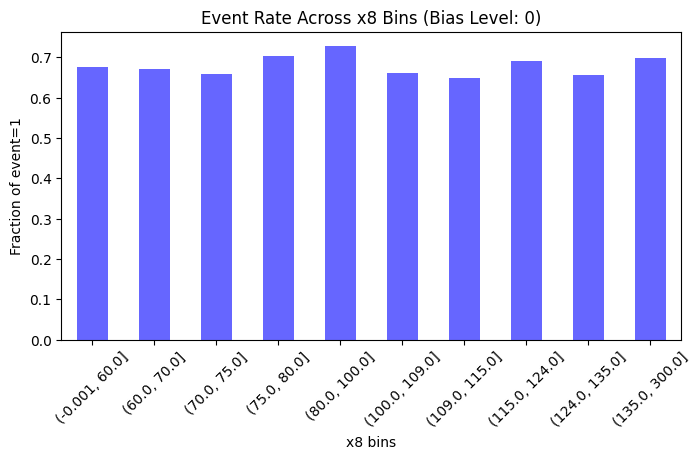

/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_38214/84681432.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin


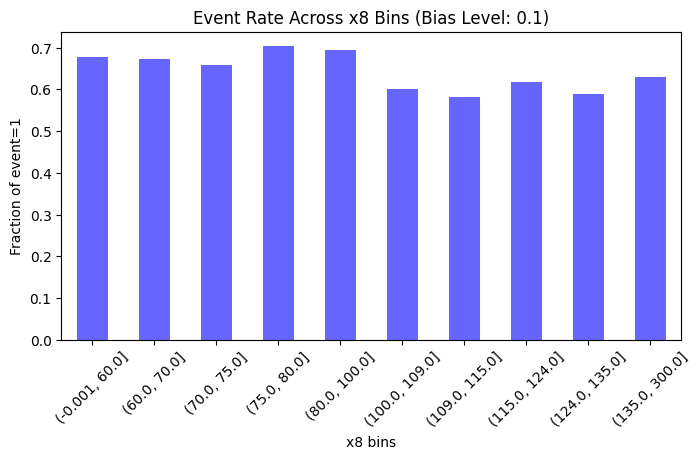

/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_38214/84681432.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin


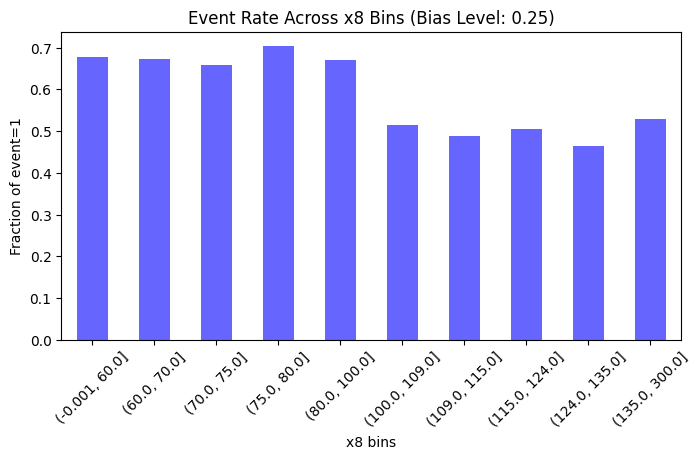

/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_38214/84681432.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin


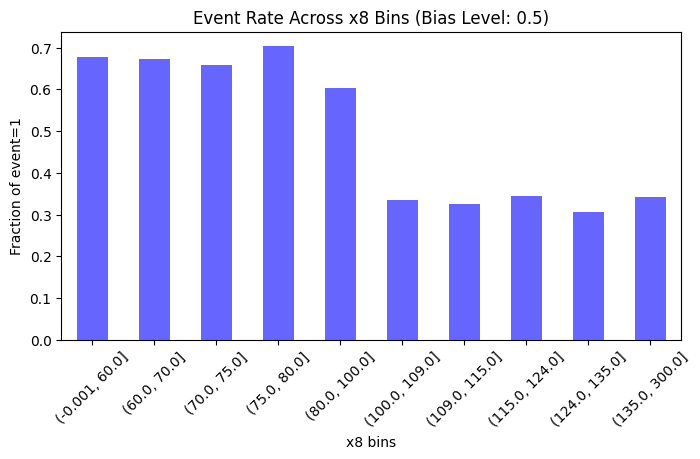

/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_38214/84681432.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin


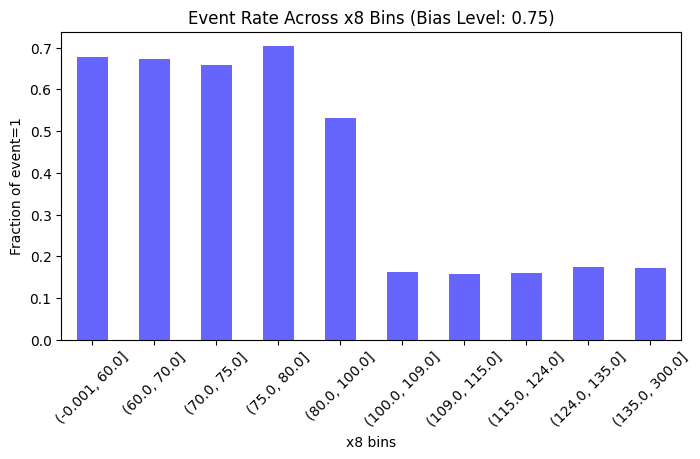

/var/folders/zv/fpk7tffn5dd3nvq2jc4mp9m80000gn/T/ipykernel_38214/84681432.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin


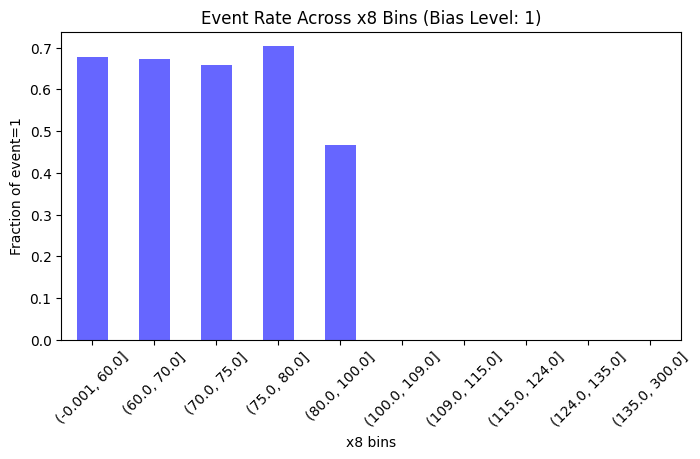

In [176]:
# For feature x8 it undoes the bias that already exists so it doesn't work
for bias_level in [0, 0.1, 0.25, 0.5, 0.75, 1]:
    biased_df = introduce_bias(processed_df["support"], bias_level, "x8")
    
    # Plot event rate across x8 bins
    df_plot = biased_df.copy()
    df_plot["x8_bin"] = pd.qcut(df_plot["x8"], q=10)  # Bin x8 into deciles
    
    censoring_rates = df_plot.groupby("x8_bin")["event"].mean()  # Mean of event=1 per bin
    
    plt.figure(figsize=(8, 4))
    censoring_rates.plot(kind="bar", color="b", alpha=0.6)
    plt.title(f"Event Rate Across x8 Bins (Bias Level: {bias_level})")
    plt.ylabel("Fraction of event=1")
    plt.xlabel("x8 bins")
    plt.xticks(rotation=45)
    plt.show()

In [177]:
for bias_level in [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]:
    print(f"Bias level: {bias_level}")
    biased_df = introduce_bias(processed_df["support"], bias_level, "x7")
    evaluate_predictive_power_split(biased_df)

Bias level: 0
Accuracy: 0.68
AUC: 0.66
Bias level: 0.1
Accuracy: 0.66
AUC: 0.66
Bias level: 0.25
Accuracy: 0.64
AUC: 0.66
Bias level: 0.5
Accuracy: 0.67
AUC: 0.72
Bias level: 0.75
Accuracy: 0.74
AUC: 0.79
Bias level: 0.9
Accuracy: 0.77
AUC: 0.84
Bias level: 1
Accuracy: 0.78
AUC: 0.87


### Task 1.4.2

In [ ]:
def partial_likelihood_with_L2_reg_and_weights(model, dataset, input_columns, lambda_reg, time_column, event_column, weights_col):
    # Compute the negative log partial likelihood with sample weights
    neg_log_likelihood = partial_likelihood_loss_with_weights(model, dataset, input_columns, time_column, event_column, weights_col)

    # Compute L2 regularization term
    l2_reg = sum(torch.sum(param ** 2) for param in model.parameters())

    # Add regularization to the loss
    total_loss = neg_log_likelihood + 0.5 * lambda_reg * l2_reg

    return total_loss

def partial_likelihood_loss_with_weights(model, dataset, input_columns, time_column="time", event_column="DEATH_EVENT", weights_col="Sample Weight"):
    # Extract features, times, events, and sample weights
    X = torch.tensor(dataset[input_columns].values, dtype=torch.float32)
    times = torch.tensor(dataset[time_column].values, dtype=torch.float32)
    events = torch.tensor(dataset[event_column].values, dtype=torch.float32)
    weights = torch.tensor(dataset[weights_col].values, dtype=torch.float32)

    # Compute linear scores and risk scores
    linear_scores = model(X).squeeze()  # Shape: (n_patients,)
    risk_scores = torch.exp(linear_scores)

    # Sort patients by time (descending)
    sorted_indices = torch.argsort(times, descending=True)
    linear_scores = linear_scores[sorted_indices]
    risk_scores = risk_scores[sorted_indices]
    events = events[sorted_indices]
    weights = weights[sorted_indices]

    # Compute log-partial likelihood
    log_cumulative_hazard = torch.log(torch.cumsum(risk_scores, dim=0))
    log_likelihood = linear_scores - log_cumulative_hazard

    # Apply sample weights
    weighted_log_likelihood = weights * events * log_likelihood
    neg_log_likelihood = -torch.sum(weighted_log_likelihood)

    return neg_log_likelihood


In [178]:
class SurvivalModelWeight(SurvivalModel):
    def __init__(self, dimensions, dropout=0.1, normalization=True, activation="ReLU"):
        self.super.__init__(dimensions, dropout, normalization, activation)
        self.weighting_model = None  

    def fit_weighting_model(self, X, TW):
        self.weighting_model = LogisticRegression()
        self.weighting_model.fit(X, TW)  # Fit model to censoring labels

    def compute_sample_weights(self, X):
        weigths = self.weighting_model.predict_proba(X)[:, 1] 
        return weigths  # Lower weight for highly censored samples

    def fit(self, X, T, C, TW, n_epochs=1000, lr=0.001, lambda_reg=0.1, save_weights=False, print_metrics=False):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)

        # Train censoring model and compute weights
        self.fit_weighting_model(X, TW)
        sample_weights = self.compute_sample_weights(X)

        dataset = pd.DataFrame(X)
        input_columns = dataset.columns.tolist()
        dataset["Survival Time"] = T
        dataset["Censor (Censor = 1)"] = C
        dataset["DEATH_EVENT"] = np.logical_not(dataset["Censor (Censor = 1)"]).astype(int)
        dataset["Sample Weight"] = sample_weights

        for epoch in range(n_epochs):
            optimizer.zero_grad()
            loss = partial_likelihood_with_L2_reg_and_weights(
                self.model, dataset, input_columns, lambda_reg, "Survival Time", "DEATH_EVENT", weights_col="Sample Weight"
            )
            loss.backward()
            optimizer.step()
            if print_metrics and epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        self.baseline_survival = self._compute_baseline_survival(T, C)

        if save_weights:
            torch.save(self.model.state_dict(), "model_weights.pth")
            with open("baseline_survival.pkl", "wb") as f:
                pickle.dump(self.baseline_survival, f)
            with open("scaler.pkl", "wb") as f:
                pickle.dump(self.scaler, f)

NameError: name 'SurvivalModel' is not defined

In [ ]:
# Training
train_data = UNOS_data.copy()
X_train, T_train, C_train = np.array(train_data[input_columns]), train_data["Survival Time"].values, train_data["Censor (Censor = 1)"].values

model = SurvivalModel(dimensions=[len(input_columns), 50, 50, 1], dropout=0.1, activation="ReLU")
model.fit(X_train, T_train, C_train, save_weights=True)

event = train_data["DEATH_EVENT"].values
risk_scores = model.predict(X_train)[:, 5]  # Use third time point as risk score proxy
c_index = concordance_index(T_train, risk_scores, event)

print(c_index)


In [1]:
# >> Write your code here <<

## References

[1] Chicco, Davide, and Giuseppe Jurman. “Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone.” BMC Medical Informatics and Decision Making, vol.
20, no. 1 (2020): 1-16.

[2] Weiss, Eric S., Lois U. Nwakanma, Stuart B. Russell, John V. Conte, and Ashish S. Shah. “Outcomes in
bicaval versus biatrial techniques in heart transplantation: an analysis of the UNOS database.” The Journal
of heart and lung transplantation, vol. 27, no. 2 (2008): 178-183.